# Tarea 6
## Alumno: Ulises Reyes García

El siguiente notebook contiene el proceso mediante el cual se ejecutan procesos PARA:

- ETL:
    - Descargar datos de BANXICO (tasa de interés, inflación y tipo de cambio)
    - Limpiar datos y convertir al formato adecuado (CSV)
    - Cargar los datos a un bucket de S3
- ELT:
    - Crear tablas en Athena
    - Ejecutar queries desde las tablas creadas para generar una 'sábana analítica' que contenga los 3 datos
    - Entrenar una regresión por cada combinación de datos
    - Mostrar resultados de las regresiones

# Importar librerías

In [2]:
import configparser
import pandas as pd
import boto3
from sie_banxico import SIEBanxico

# Descargar config file

El siguiente archivo contiene las credenciales y parámetros requeridos para ejecutar nuestros procesos.

In [5]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

# Descargar datos de Banxico

Los datos requeridos para nuestro análisis pueden ser extraídos desde el servicio de BANXICO:

- Tasa de interés (CETES a 365 días)
- Inflación mensual (vía INPC)
- Tipo de cambio FIX MXN/USD

Importamos nuestra credencial para el servicio de BANXICO:

In [6]:
banxico_token = config['banxico']['token']

Descargamos tablas usando los ID's pertinentes:

In [36]:
# Tipo de cambio FIX: SF17908
# Inflación (INPC) mensual : SP30577
# CETES 364 días: SF3367

api = SIEBanxico(token = banxico_token, id_series = ['SF17908' ,'SP30577', 'SF3367'], language = 'es')

In [37]:
series_banxico = api.get_timeseries()

# Limpiar datos

Las series son expuestas en un formato de diccionario. Es necesario crear dataframe de Pandas para poder manipular la información:

In [81]:
df_indicadores = {}

for series in series_banxico['bmx']['series']:
    df_indicadores[series['idSerie']] = pd.DataFrame(series['datos'])

Limpiamos los datos nulos (representados por el string 'N/E') y convertimos las fechas al formato adecuado.

In [83]:
for series in df_indicadores.keys():
    df_indicadores[series] = df_indicadores[series][df_indicadores[series]['dato']!='N/E']
    df_indicadores[series]['fecha'] = pd.to_datetime(df_indicadores[series]['fecha'], format = "%d/%m/%Y")

Renombramos nombres de columnas:

In [84]:
df_indicadores['SF17908'] = df_indicadores['SF17908'].rename({'dato':'tipo_cambio'}, axis = 1)
df_indicadores['SP30577'] = df_indicadores['SP30577'].rename({'dato':'inflacion_inpc'}, axis = 1)
df_indicadores['SF3367'] = df_indicadores['SF3367'].rename({'dato':'cetes_365'}, axis = 1)

# Guardar datos en CSV

In [87]:
df_indicadores['SF17908'].to_csv('datos/tipo_de_cambio.csv', encoding = 'utf-8', index = False)
df_indicadores['SP30577'].to_csv('datos/inflacion.csv', encoding = 'utf-8', index = False)
df_indicadores['SF3367'].to_csv('datos/tasa_de_interes.csv', encoding = 'utf-8', index = False)

# Cargar datos a AWS (S3)

In [88]:
session = boto3.Session(profile_name='arquitectura')
s3 = session.client('s3')

In [89]:
BUCKET_NAME = "itam-analytics-ulisesrg"

s3.upload_file(Filename="datos/tipo_de_cambio.csv", Bucket=BUCKET_NAME, Key="econ/raw/tipo_de_cambio/tipo_de_cambio.csv")
s3.upload_file(Filename="datos/inflacion.csv", Bucket=BUCKET_NAME, Key="econ/raw/inflacion/inflacion.csv")
s3.upload_file(Filename="datos/tasa_de_interes.csv", Bucket=BUCKET_NAME, Key="econ/raw/tasa_de_interes/tasa_de_interes.csv")

# Crear base de datos en AWS (Glue)

In [90]:
from botocore.config import Config
my_config = Config(
    region_name = 'us-east-1'
)

glue = boto3.client('glue', config=my_config)

In [91]:
response = glue.create_database(
    DatabaseInput={
        'Name': 'econ',
        'Description': 'Datos de inflación, tipo de cambio y tasa de interés.',
    },
)
response

{'ResponseMetadata': {'RequestId': '12322ac7-4c1d-40c4-afe7-d573bbfcbeb5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 18 Mar 2025 17:43:49 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '12322ac7-4c1d-40c4-afe7-d573bbfcbeb5',
   'cache-control': 'no-cache'},
  'RetryAttempts': 0}}

# Crear tablas en AWS (Athena)

In [92]:
import awswrangler as wr

### Inflación

In [94]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `econ`.`inflacion` (
    `fecha` date,
    `inflacion_inpc` float
    ) COMMENT "Inflación mensual vía INPC."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' 
    OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-ulisesrg/econ/raw/inflacion/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [95]:
wr.athena.read_sql_query(
    query, 
    database="econ", 
    ctas_approach=False, 
    boto3_session=session
)

""


### Tipo de Cambio

In [96]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `econ`.`tipo_de_cambio` (
    `fecha` date,
    `tipo_cambio` float
    ) COMMENT "Inflación mensual vía INPC."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' 
    OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-ulisesrg/econ/raw/tipo_de_cambio/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [97]:
wr.athena.read_sql_query(
    query, 
    database="econ", 
    ctas_approach=False, 
    boto3_session=session
)

""


### Tasa de Interés

In [98]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `econ`.`tasa_de_interes` (
    `fecha` date,
    `cetes_365` float
    ) COMMENT "Inflación mensual vía INPC."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' 
    OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-ulisesrg/econ/raw/tasa_de_interes/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [99]:
wr.athena.read_sql_query(
    query, 
    database="econ", 
    ctas_approach=False, 
    boto3_session=session
)

""


### Query y creación de tabla única

El siguiente query crea, mediante un JOIN, una tabla única que combina mis 3 tipos de datos mensuales en una sola tabla:

In [112]:
query = '''
    SELECT inf.fecha, inf.inflacion_inpc, cam.tipo_cambio, int.cetes_365
    FROM "econ"."inflacion" as inf
    INNER JOIN "econ"."tipo_de_cambio" as cam
    ON inf.fecha = cam.fecha
    INNER JOIN "econ"."tasa_de_interes" as int
    ON inf.fecha = int.fecha;
'''

Guardo el resultado del query anterior en un objeto 'df' de Pandas:

In [116]:
df = wr.athena.read_sql_query(
    query, 
    database="econ", 
    ctas_approach=False, 
    boto3_session=session
)

### Entrenamiento de Regresiones y Scatter Plots

In [115]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [119]:
# 4. Regresiones
# 4.1. tipo_de_cambio ~ tasa_de_interes
X = df[['cetes_365']]
X = sm.add_constant(X)  # Agregar término constante
y = df['tipo_cambio']

model_tc_ti = sm.OLS(y, X).fit()

In [120]:
# 4.2. tasa_de_interes ~ inflacion
X2 = df[['inflacion_inpc']]
X2 = sm.add_constant(X2)
y2 = df['cetes_365']

model_ti_inf = sm.OLS(y2, X2).fit()

In [121]:
# 4.3. tipo_de_cambio ~ inflacion
X3 = df[['inflacion_inpc']]
X3 = sm.add_constant(X3)
y3 = df['tipo_cambio']

model_tc_inf = sm.OLS(y3, X3).fit()

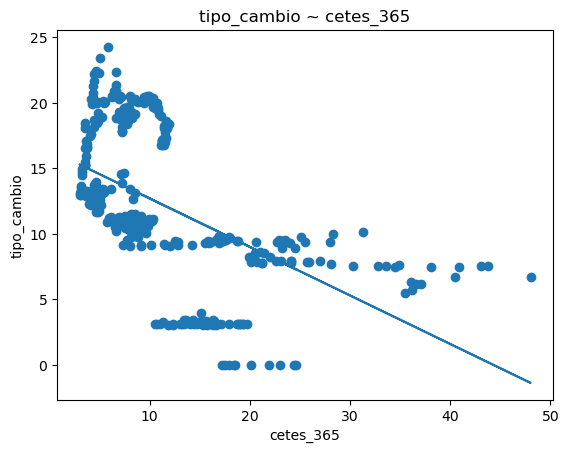

In [ ]:
# 5. Gráficas
# (1) Scatter tipo_de_cambio vs tasa_de_interes con línea de regresión
plt.figure()
plt.scatter(df['cetes_365'], df['tipo_cambio'])
# Calculamos el fit
pred_line = model_tc_ti.predict(sm.add_constant(df[['cetes_365']]))
plt.plot(df['cetes_365'], pred_line)
plt.xlabel('cetes_365')
plt.ylabel('tipo_cambio')
plt.title('tipo_cambio ~ cetes_365')
plt.show()

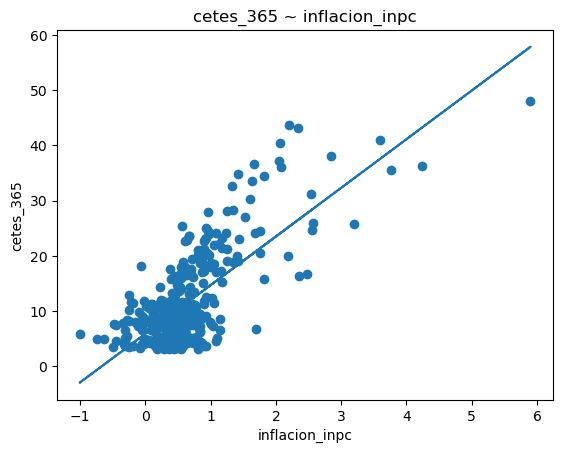

In [123]:
# (2) Scatter tasa_de_interes vs inflacion con línea de regresión
plt.figure()
plt.scatter(df['inflacion_inpc'], df['cetes_365'])
pred_line2 = model_ti_inf.predict(sm.add_constant(df[['inflacion_inpc']]))
plt.plot(df['inflacion_inpc'], pred_line2)
plt.xlabel('inflacion_inpc')
plt.ylabel('cetes_365')
plt.title('cetes_365 ~ inflacion_inpc')
plt.show()

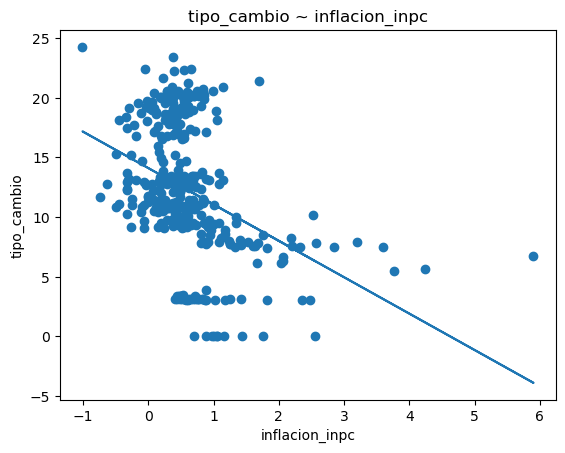

In [124]:
# (3) Scatter tipo_de_cambio vs inflacion con línea de regresión
plt.figure()
plt.scatter(df['inflacion_inpc'], df['tipo_cambio'])
pred_line3 = model_tc_inf.predict(sm.add_constant(df[['inflacion_inpc']]))
plt.plot(df['inflacion_inpc'], pred_line3)
plt.xlabel('inflacion_inpc')
plt.ylabel('tipo_cambio')
plt.title('tipo_cambio ~ inflacion_inpc')
plt.show()